![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <Center>Segmentación de clientes según datos bancarios</Center>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import warnings
import sweetviz as sv

from numpy.random import uniform
from ucimlrepo import fetch_ucirepo 
from random import sample
from math import isnan
from scipy.cluster.hierarchy import dendrogram, linkage
from pywaffle import Waffle
from matplotlib.patches import Rectangle
from yellowbrick.style import set_palette
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from IPython.display import display, HTML
from collections import Counter

from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from imblearn.over_sampling import RandomOverSampler

# --- Libraries Settings ---
warnings.filterwarnings('ignore')
class clr:
    start = '\033[91m'+'\033[1m'
    color = '\033[94m'
    end = '\033[0m'

## DATASET

### IMPORT

In [2]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
df = statlog_german_credit_data.data.original

# dataframe shape
print(clr.start+"Shape:",clr.color+'{}'.format(df.shape))

# Formatear los metadatos como una tabla HTML
table_content = '<table>'
table_content += '<tr><th style="color:lightcoral; font-weight:bold">Key</th><th style="color:steelblue; font-weight:bold; text-align:center">Value</th></tr>'
for key, value in statlog_german_credit_data.metadata.items():
    table_content += '<tr>'
    table_content += f'<td style="color:lightcoral">{key}</td>'
    if isinstance(value, dict):  # Si el valor es un diccionario, mostrarlo como una tabla
        table_content += '<td>'
        table_content += '<table>'
        for subkey, subvalue in value.items():
            table_content += f'<tr><td style="color:steelblue">{subkey}</td><td style="color:lightblue; text-align:center">{subvalue}</td></tr>'
        table_content += '</table>'
        table_content += '</td>'
    else:
        table_content += f'<td style="color:steelblue; text-align:center">{value}</td>'
    table_content += '</tr>'
table_content += '</table>'

# Mostrar la tabla HTML con los metadatos
display(HTML(table_content))

Shape: (1000, 21)


Key,Value
uci_id,144
name,Statlog (German Credit Data)
repository_url,https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
data_url,https://archive.ics.uci.edu/static/public/144/data.csv
abstract,This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix
area,Social Science
tasks,['Classification']
characteristics,['Multivariate']
num_instances,1000
num_features,20


### OVERVIEW

In [3]:
# variable information 
df_variables = statlog_german_credit_data.variables
df_variables.style.hide(axis="index")

name,role,type,demographic,description,units,missing_values
Attribute1,Feature,Categorical,None,Status of existing checking account,None,no
Attribute2,Feature,Integer,None,Duration,months,no
Attribute3,Feature,Categorical,None,Credit history,None,no
Attribute4,Feature,Categorical,None,Purpose,None,no
Attribute5,Feature,Integer,None,Credit amount,None,no
Attribute6,Feature,Categorical,None,Savings account/bonds,None,no
Attribute7,Feature,Categorical,Other,Present employment since,None,no
Attribute8,Feature,Integer,None,Installment rate in percentage of disposable income,None,no
Attribute9,Feature,Categorical,Marital Status,Personal status and sex,None,no
Attribute10,Feature,Categorical,None,Other debtors / guarantors,None,no


In [4]:
df.head().style.hide(axis="index")

Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


### ANÁLISIS

In [5]:
# Generar un informe de análisis exploratorio de datos
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


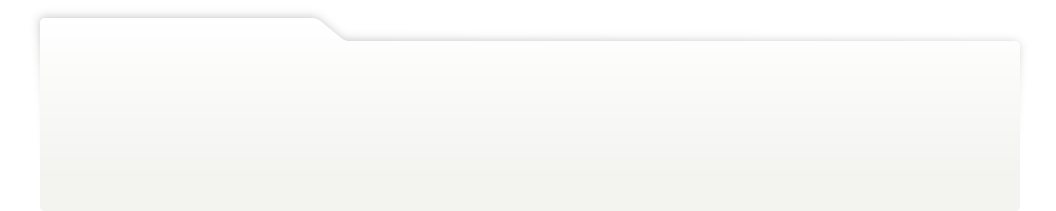
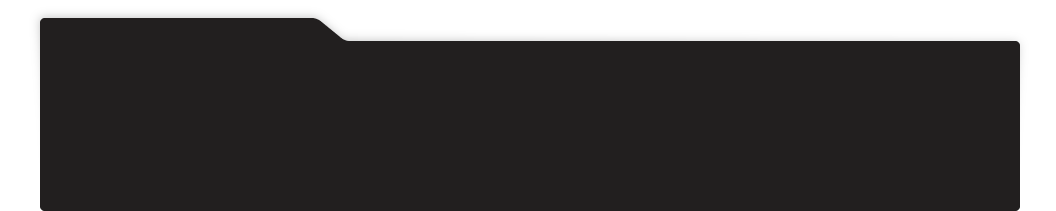
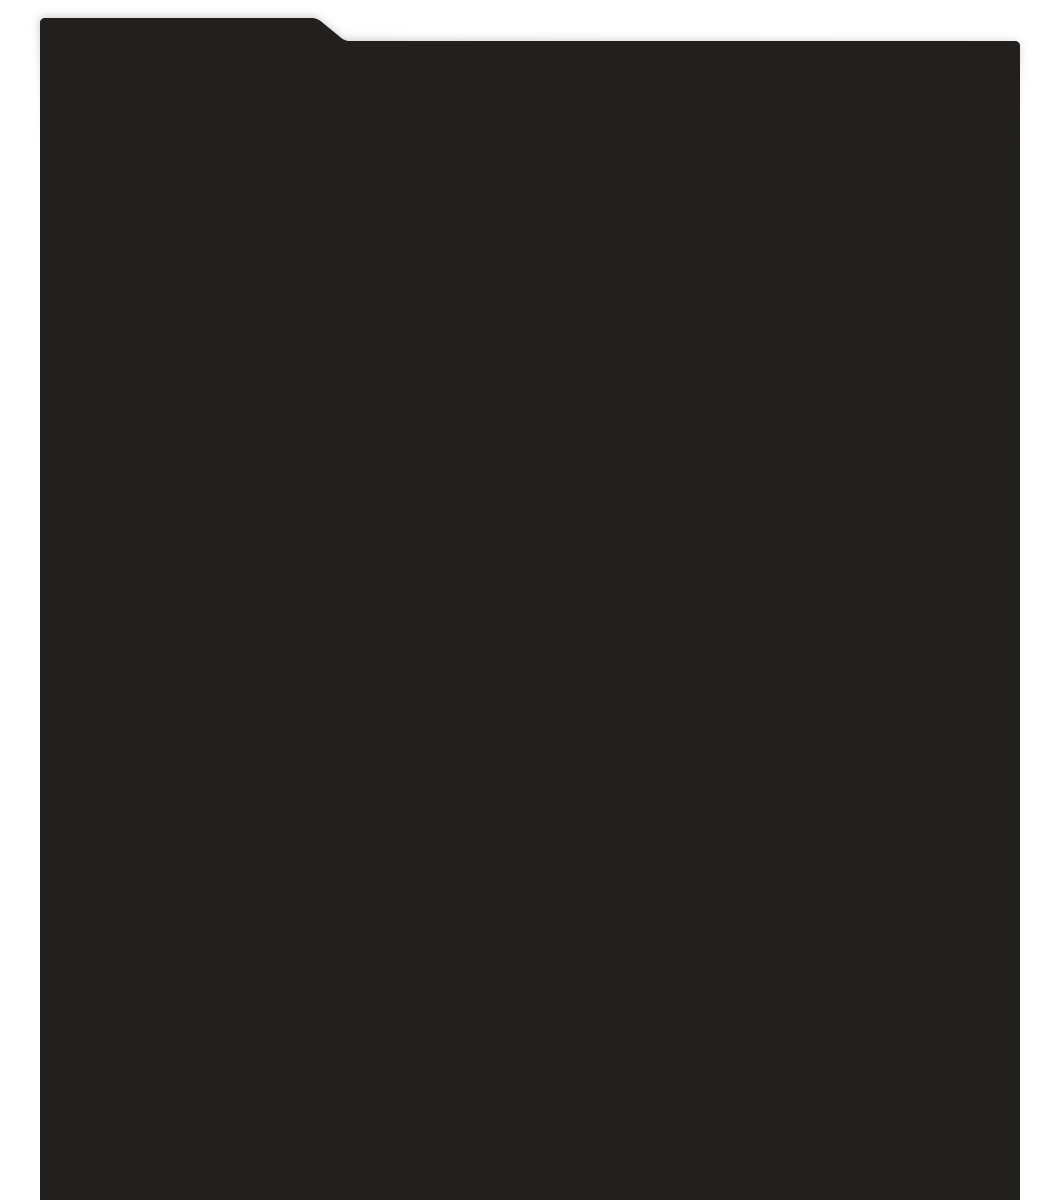
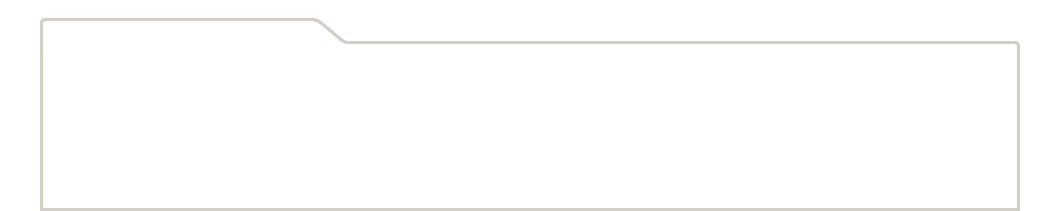
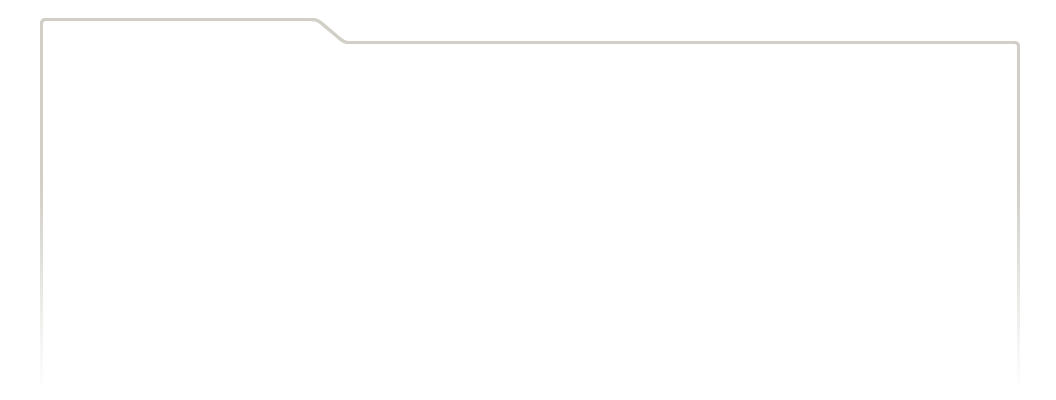
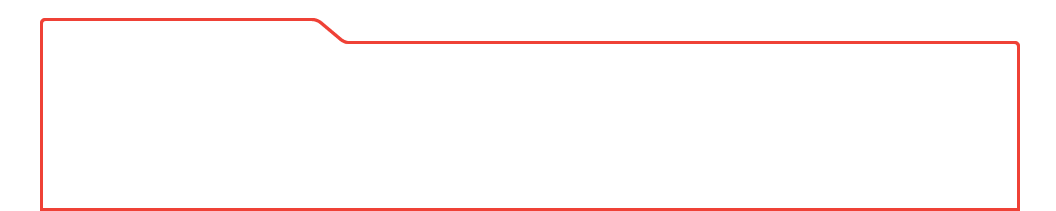
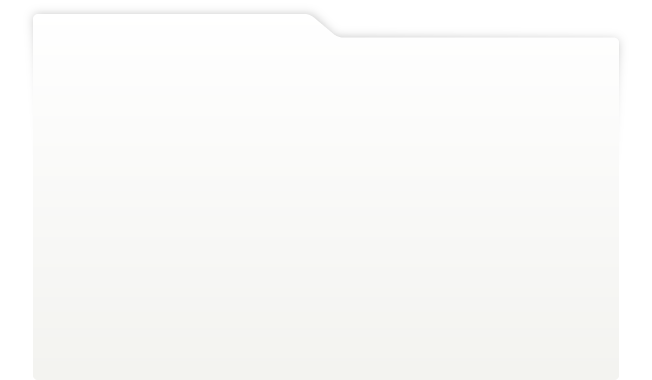
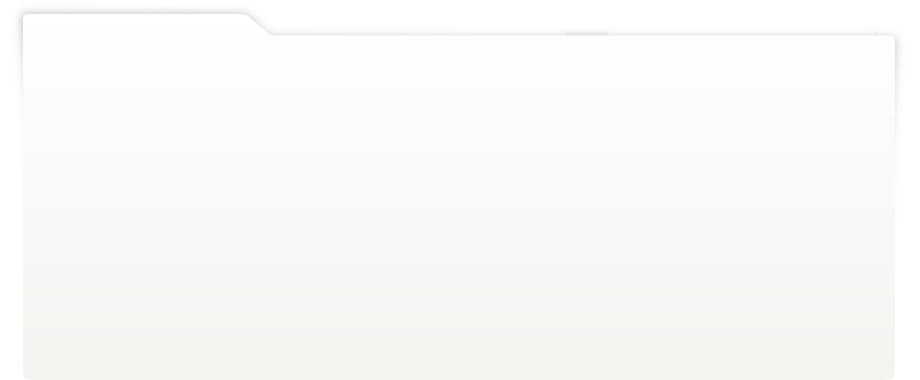
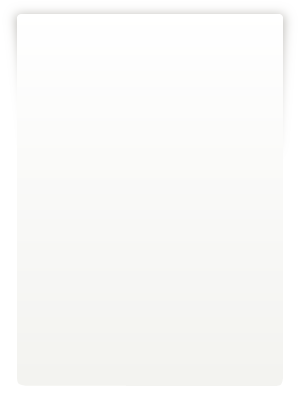
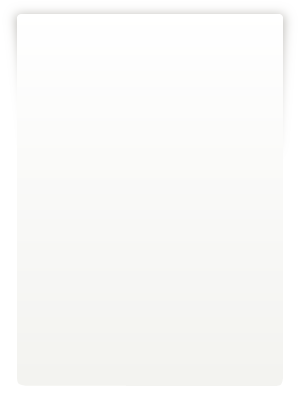
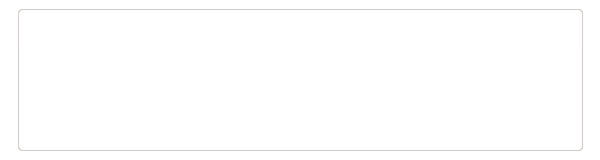
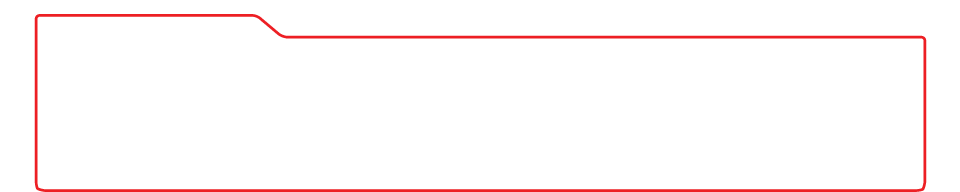
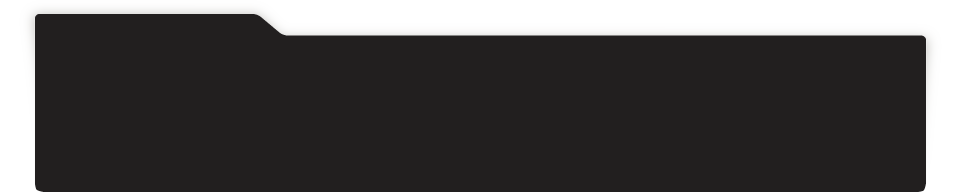
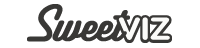
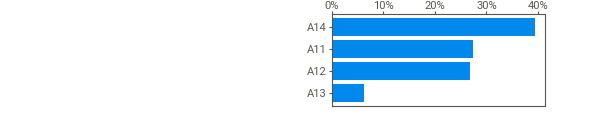
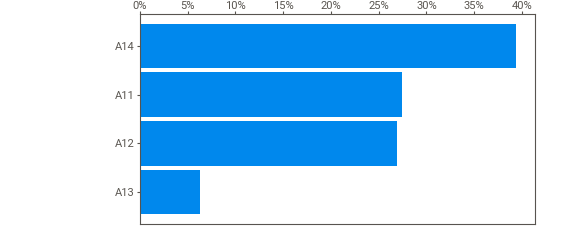
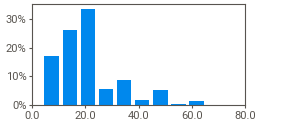
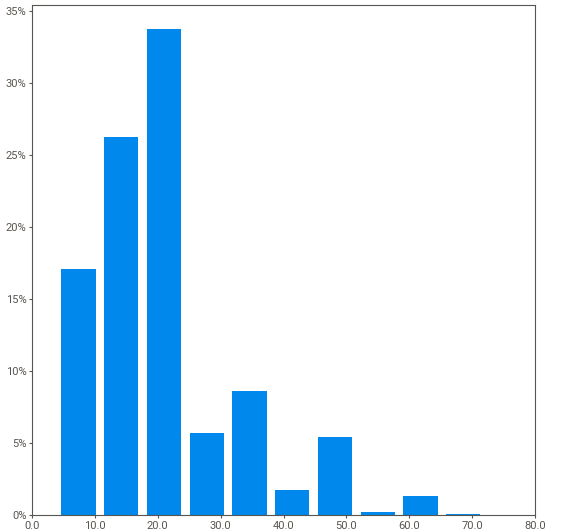
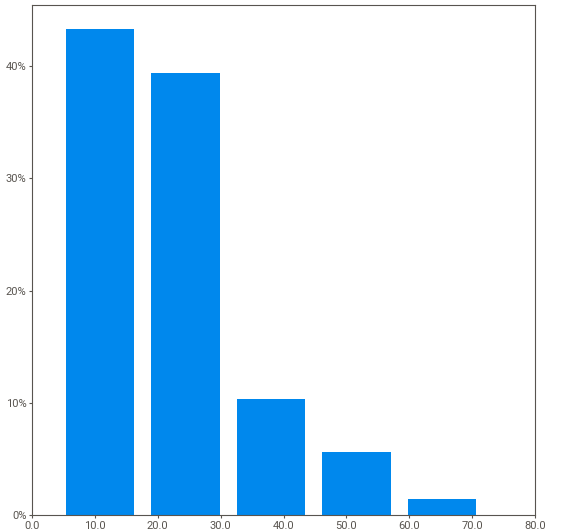
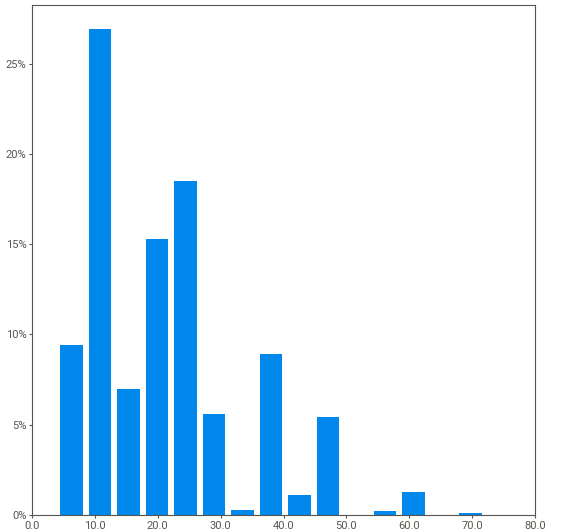
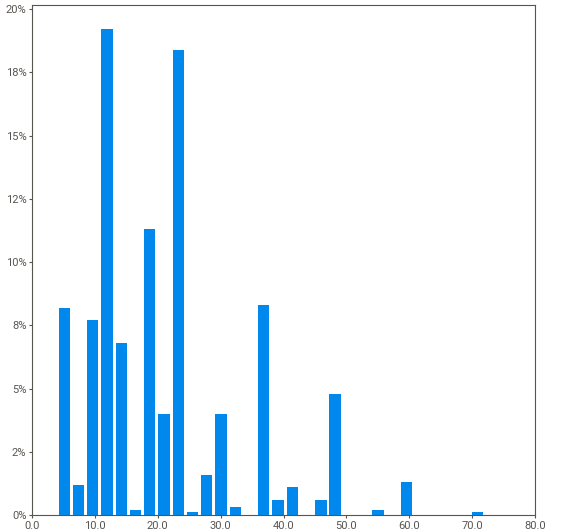
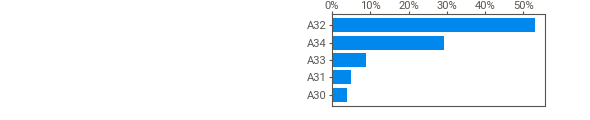
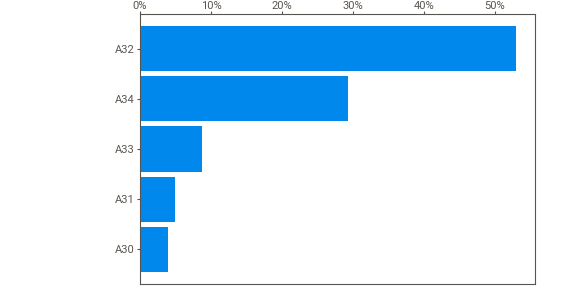
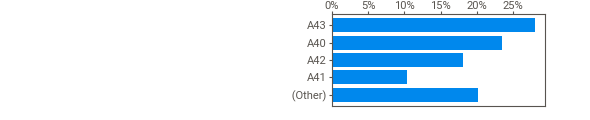
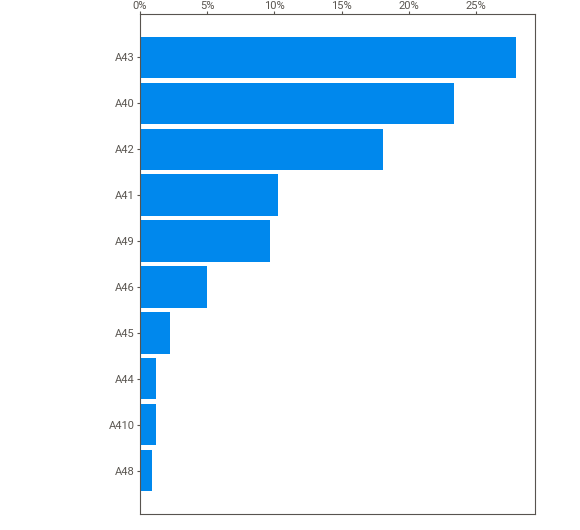
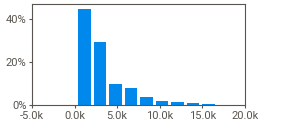
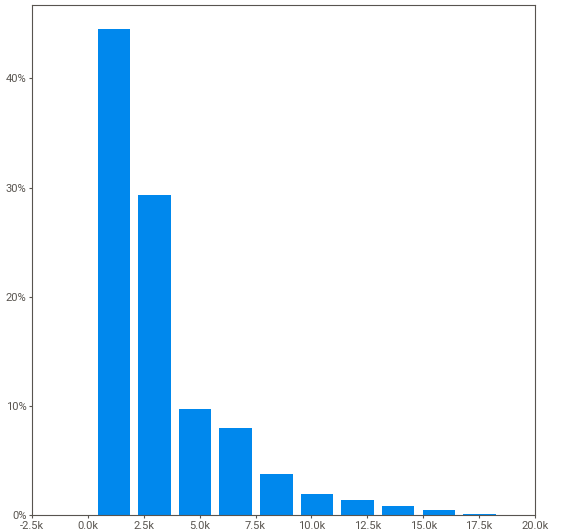
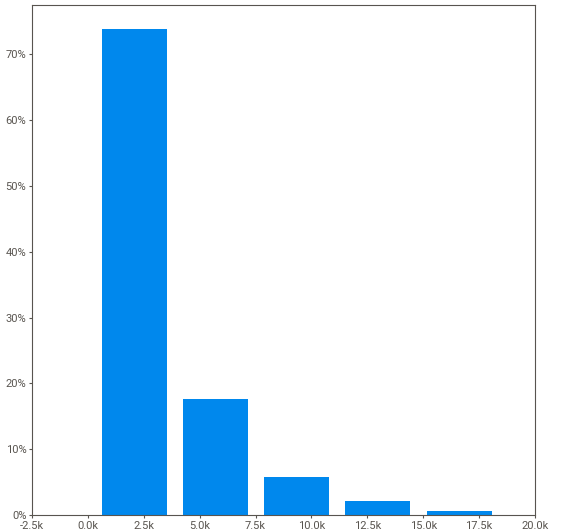
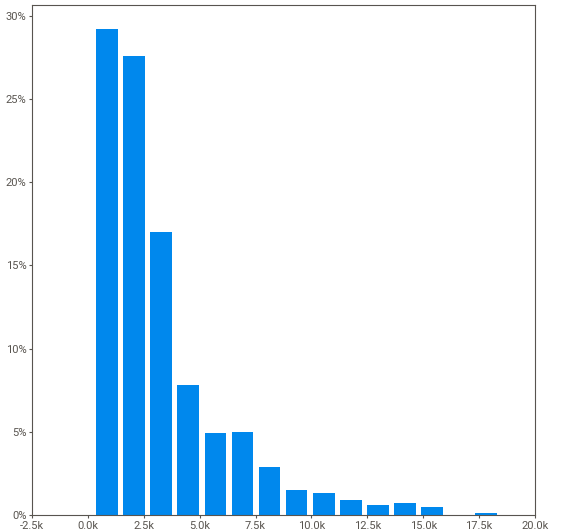
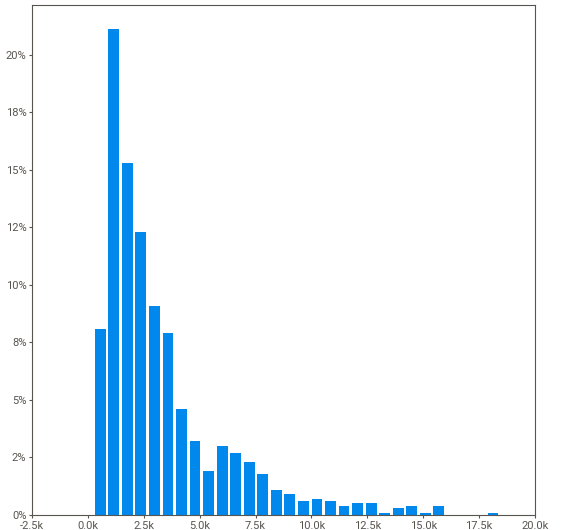
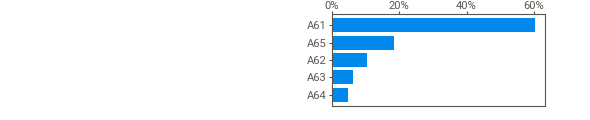
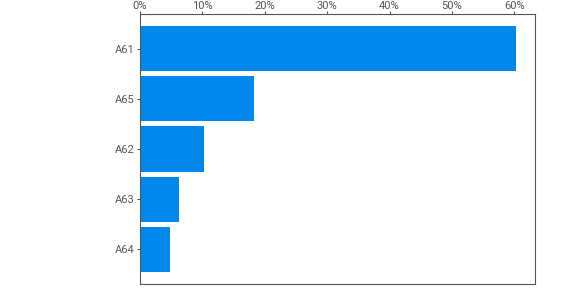
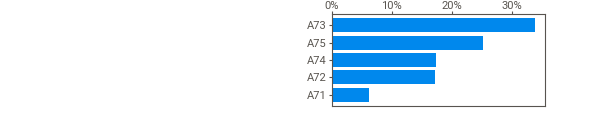
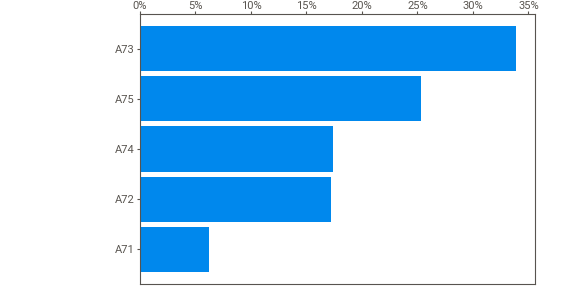
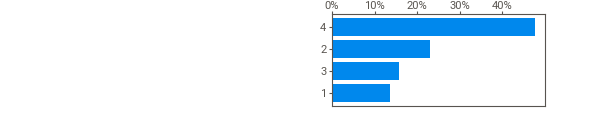
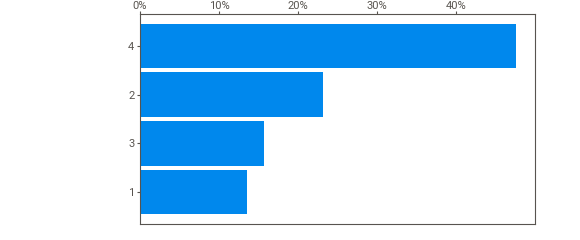
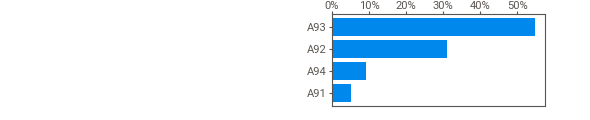
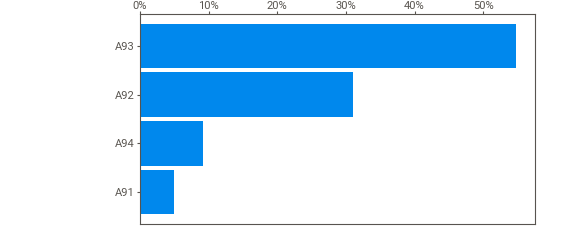
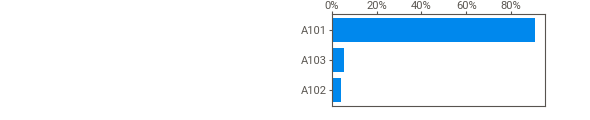
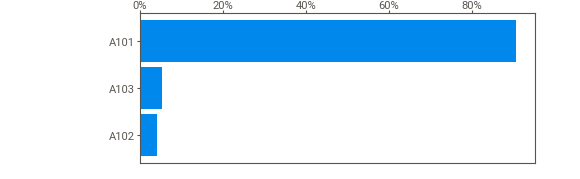
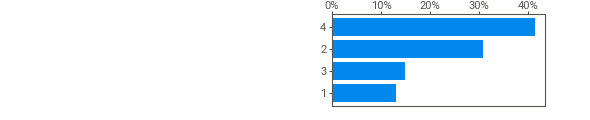
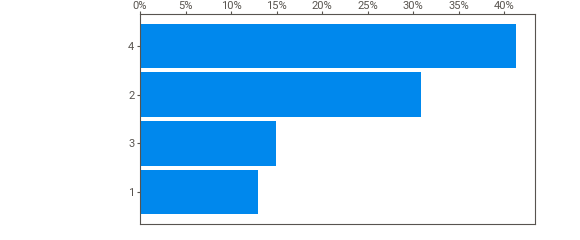
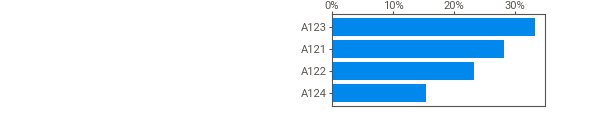
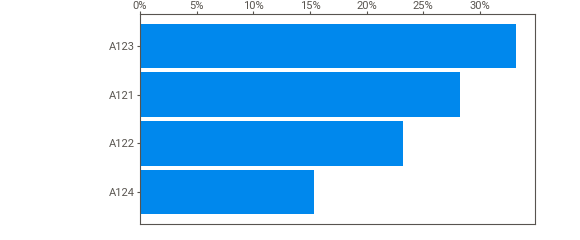
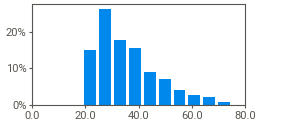
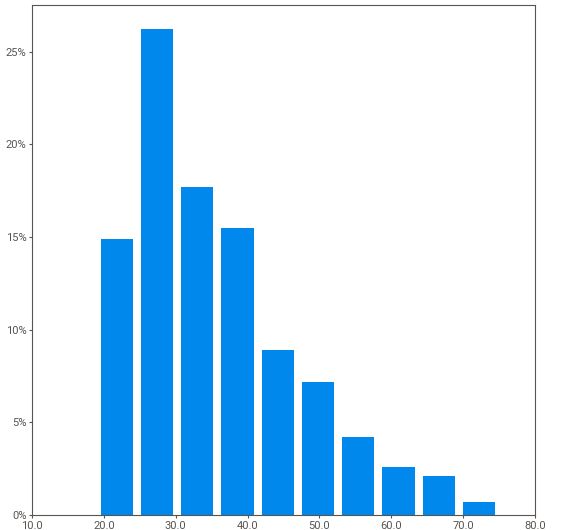
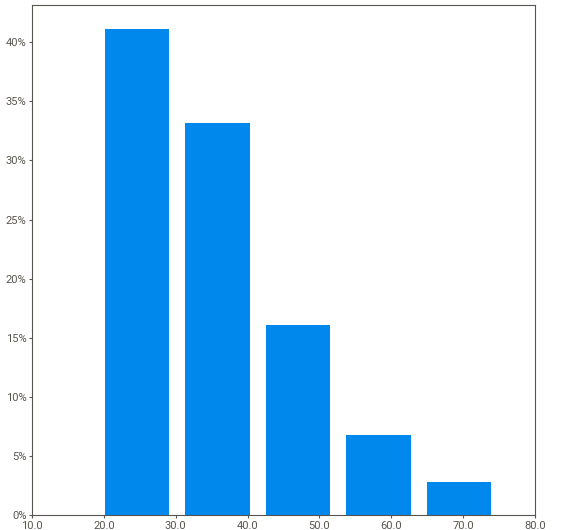
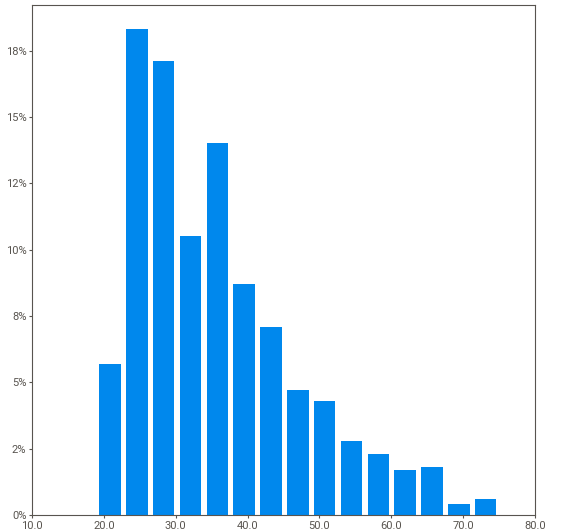
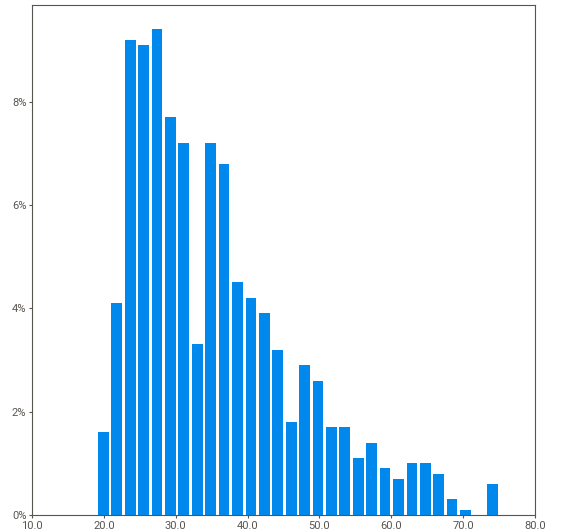
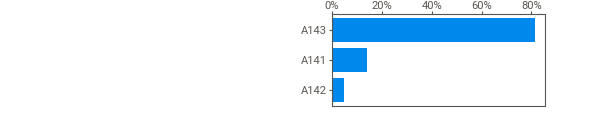
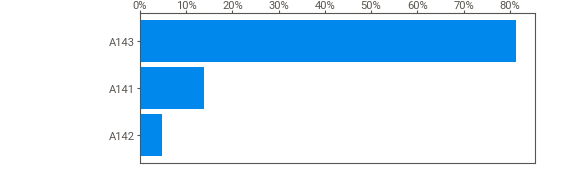
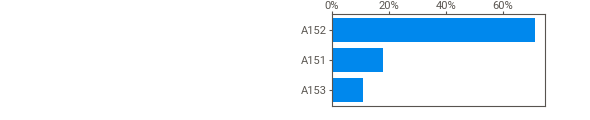
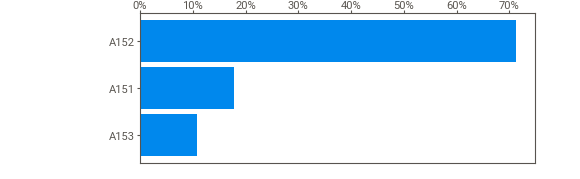
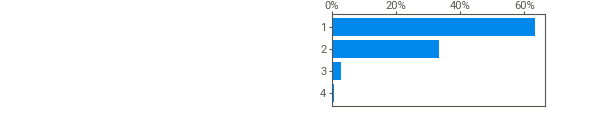
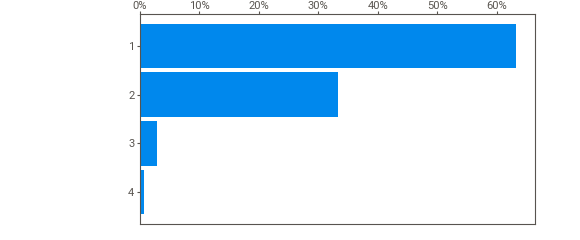
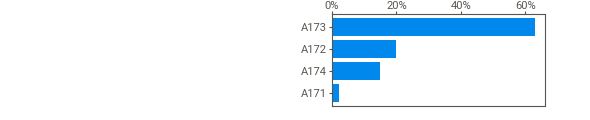
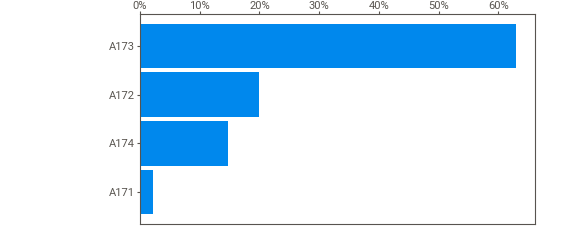
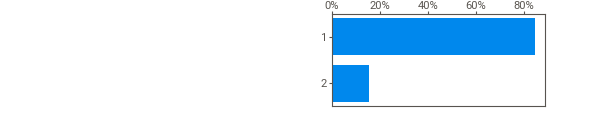
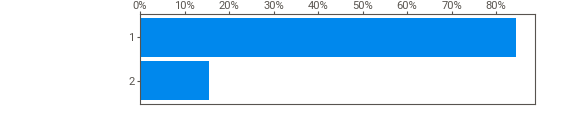
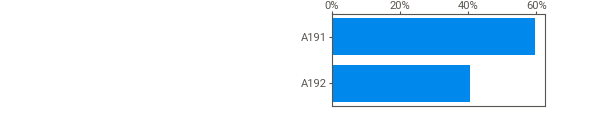
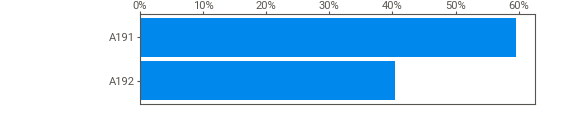
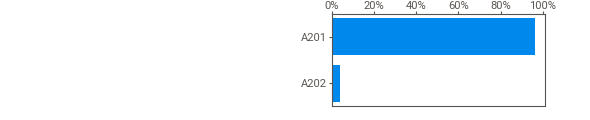
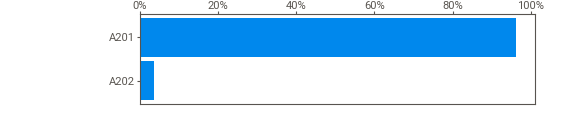
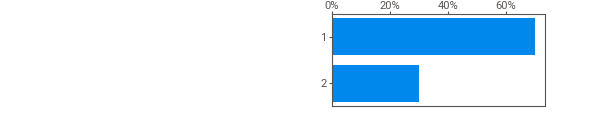
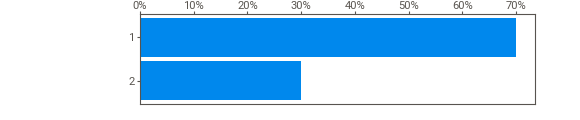
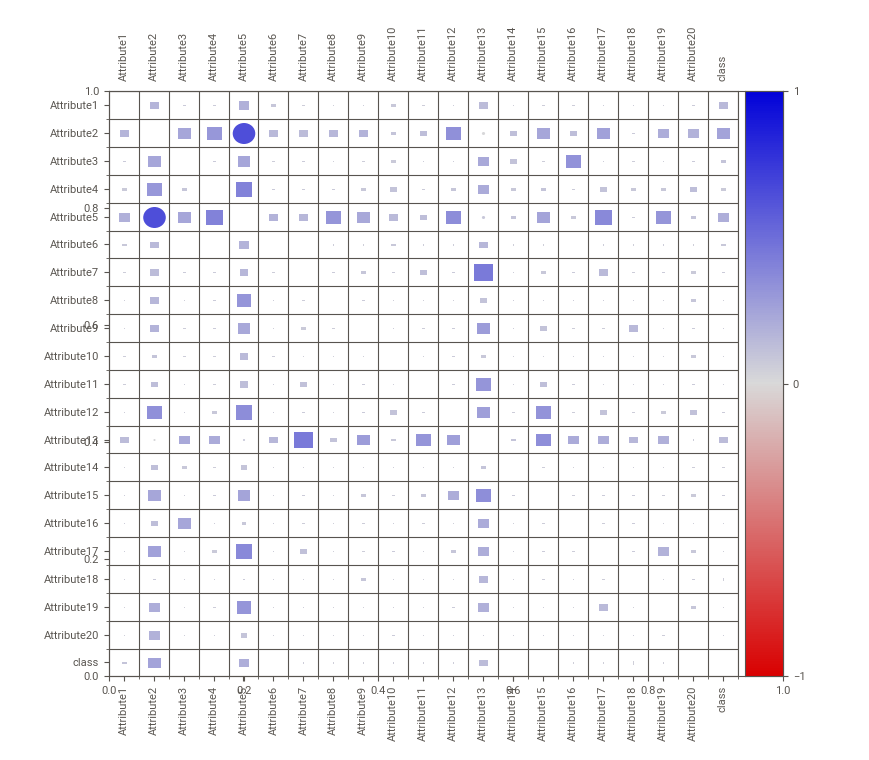
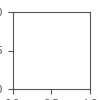

In [6]:
# Mostrar el informe
report.show_notebook(layout='widescreen')

## Preparar Dataset

### CONVERTIR VALORES A NÚMERICOS

In [7]:
# Conversión de variables catgóricas a numéricas
le = LabelEncoder()

pd.options.mode.copy_on_write = True # Para que no muestre el warning

categorical_columns = df_variables.loc[df_variables['type'] == 'Categorical', 'name'].tolist()

# Añadimos las columnas Attribute19 y Attribute20, porque pese a tener el type = binary 
# en la tabla de variables, contienen variables str
additional_columns = ['Attribute19', 'Attribute20']

categorical_columns.extend(additional_columns)

print(clr.start+"Columnas convertidas:", clr.color+'{}'.format(categorical_columns))

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Columnas convertidas: ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20']


### NORMALIZACIÓN

In [8]:
column_names = df.columns.values

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
X = pd.DataFrame(scaled_data, columns=column_names)

In [9]:
X.head().style.hide(axis="index")

Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
-1.254566,-1.236478,1.344014,0.264068,-0.745131,1.833169,1.338078,0.918477,0.449326,-0.303686,1.046987,-1.293723,2.766456,0.460831,0.133710,1.027079,0.146949,-0.428290,1.214598,-0.196014,-0.654654
-0.459026,2.248194,-0.503428,0.264068,0.949817,-0.699707,-0.317959,-0.870183,-0.963650,-0.303686,-0.765977,-1.293723,-1.191404,0.460831,0.133710,-0.704926,0.146949,-0.428290,-0.823318,-0.196014,1.527525
1.132053,-0.738668,1.344014,1.359785,-0.416562,-0.699707,0.510060,-0.870183,0.449326,-0.303686,0.140505,-1.293723,1.183312,0.460831,0.133710,-0.704926,-1.383771,2.334869,-0.823318,-0.196014,-0.654654
-1.254566,1.750384,-0.503428,-0.101171,1.634247,-0.699707,0.510060,-0.870183,0.449326,3.885083,1.046987,-0.341055,0.831502,0.460831,2.016956,-0.704926,0.146949,2.334869,-0.823318,-0.196014,-0.654654
-1.254566,0.256953,0.420293,-1.196889,0.566664,-0.699707,-0.317959,0.024147,0.449326,-0.303686,1.046987,1.564281,1.535122,0.460831,2.016956,1.027079,0.146949,2.334869,-0.823318,-0.196014,1.527525


### HOPKINS TEST

In [10]:
# --- Hopkins Test (codes by Matevž Kunaver) ---
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return H

# --- Perform Hopkins Test ---
hopkins_value = hopkins(X)
hopkins_result = 'Resultado: '+clr.color+'{:.4f}'.format(hopkins_value)+clr.end
print(clr.start+'.: Hopkins Test :.'+clr.end)
print(clr.start+'*' * 19+clr.end)
print(hopkins_result)
if  0.7 < hopkins_value < 0.99:
    print('>> Según el resultado anterior, '+clr.color+' tiene una alta tendencia a agruparse (contiene agrupaciones significativas)'+clr.end)
    print('\n'+clr.start+'*' * 31+clr.end)
    print(clr.start+'.:. Conclusiones: Aceptamos H0 .:.'+clr.end)
    print(clr.start+'*' * 31+clr.end)
else:
    print('>> Según el resultado anterior, '+clr.color+' No contiene agrupaciones significativas'+clr.end)
    print('\n'+clr.start+'*' * 31+clr.end)
    print(clr.start+'.:. Conclusiones: Rechazamos H0 .:.'+clr.end)
    print(clr.start+'*' * 31+clr.end)

.: Hopkins Test :.
*******************
Resultado: 0.6659
>> Según el resultado anterior,  No contiene agrupaciones significativas

*******************************
.:. Conclusiones: Rechazamos H0 .:.
*******************************


### PCA

In [11]:
columns = X.columns

# Reducimos la dimensionalidad de los datos (a dos dimensiones)
pca = PCA(n_components = 2)
X = pca.fit_transform(X)
# Mostramos el porcentaje de varianza explicada por cada uno de los componentes seleccionados.
print(clr.color+'{}'.format(pca.explained_variance_ratio_))

# Visualizar la "importancia" de cada variable original del problema en las nuevas dimensiones
pd.DataFrame(np.matrix.transpose(pca.components_), columns=['PC-1', 'PC-2'], index= columns)

[0.12111642 0.1019251 ]


,PC-1,PC-2
Attribute1,0.005823,0.328902
Attribute2,0.410367,-0.216894
Attribute3,0.014731,0.415422
Attribute4,0.014197,-0.038463
Attribute5,0.421876,-0.199063
Attribute6,0.086542,0.205854
Attribute7,0.167439,0.323872
Attribute8,0.047567,0.100224
Attribute9,0.024394,0.143962
Attribute10,-0.123337,-0.065111


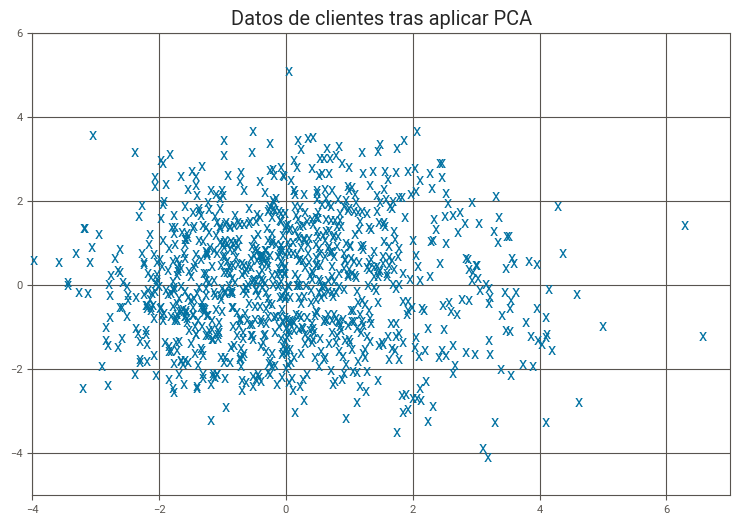

In [12]:
# Visualizar el dataset utilizando las dos dimensiones obtenidas en el PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
for i in range(len(X)):
    plt.text(X[i][0], X[i][1], 'x', color="b")
plt.xlim(-4, 7)
plt.ylim(-5, 6)
plt.title("Datos de clientes tras aplicar PCA")
plt.grid()
plt.show()

## CLUSTERING

### K-Means

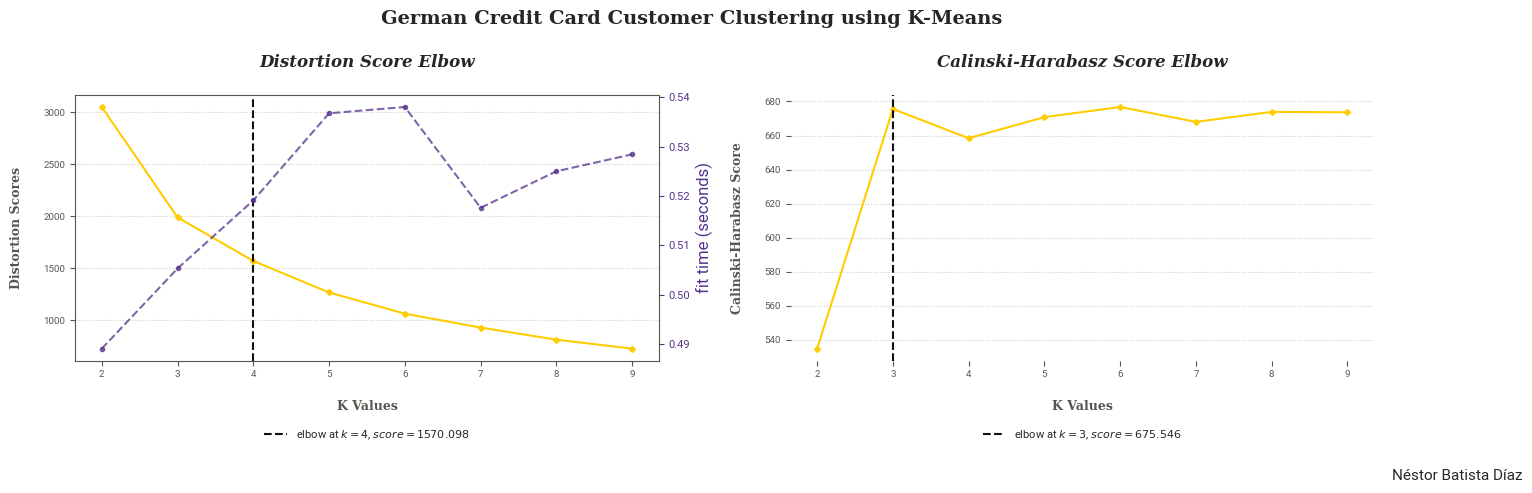

In [13]:
# --- Define K-Means Functions ---
def kmeans():
    
    # --- Figures Settings ---
    color_palette=['#FFCC00', '#54318C']
    set_palette(color_palette)
    title=dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    text_style=dict(fontweight='bold', fontfamily='serif')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- Elbow Score ---
    elbow_score = KElbowVisualizer(KMeans(random_state=32, max_iter=500), k=(2, 10), ax=ax1)
    elbow_score.fit(X)
    elbow_score.finalize()
    elbow_score.ax.set_title('Distortion Score Elbow\n', **title)
    elbow_score.ax.tick_params(labelsize=7)
    for text in elbow_score.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in elbow_score.ax.spines.values():
        spine.set_color('None')
    elbow_score.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), borderpad=2, frameon=False, fontsize=8)
    elbow_score.ax.grid(axis='y', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    elbow_score.ax.grid(axis='x', alpha=0)
    elbow_score.ax.set_xlabel('\nK Values', fontsize=9, **text_style)
    elbow_score.ax.set_ylabel('Distortion Scores\n', fontsize=9, **text_style)
    
    # --- Elbow Score (Calinski-Harabasz Index) ---
    elbow_score_ch = KElbowVisualizer(KMeans(random_state=32, max_iter=500), k=(2, 10), metric='calinski_harabasz', timings=False, ax=ax2)
    elbow_score_ch.fit(X)
    elbow_score_ch.finalize()
    elbow_score_ch.ax.set_title('Calinski-Harabasz Score Elbow\n', **title)
    elbow_score_ch.ax.tick_params(labelsize=7)
    for text in elbow_score_ch.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in elbow_score_ch.ax.spines.values():
        spine.set_color('None')
    elbow_score_ch.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), borderpad=2, frameon=False, fontsize=8)
    elbow_score_ch.ax.grid(axis='y', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    elbow_score_ch.ax.grid(axis='x', alpha=0)
    elbow_score_ch.ax.set_xlabel('\nK Values', fontsize=9, **text_style)
    elbow_score_ch.ax.set_ylabel('Calinski-Harabasz Score\n', fontsize=9, **text_style)
    
    plt.suptitle('German Credit Card Customer Clustering using K-Means', fontsize=14, **text_style)
    plt.tight_layout()
    plt.gcf().text(1, 0.04, 'Néstor Batista Díaz', style='italic', fontsize=11)
    plt.show();

# --- Calling K-Means Functions ---
kmeans();

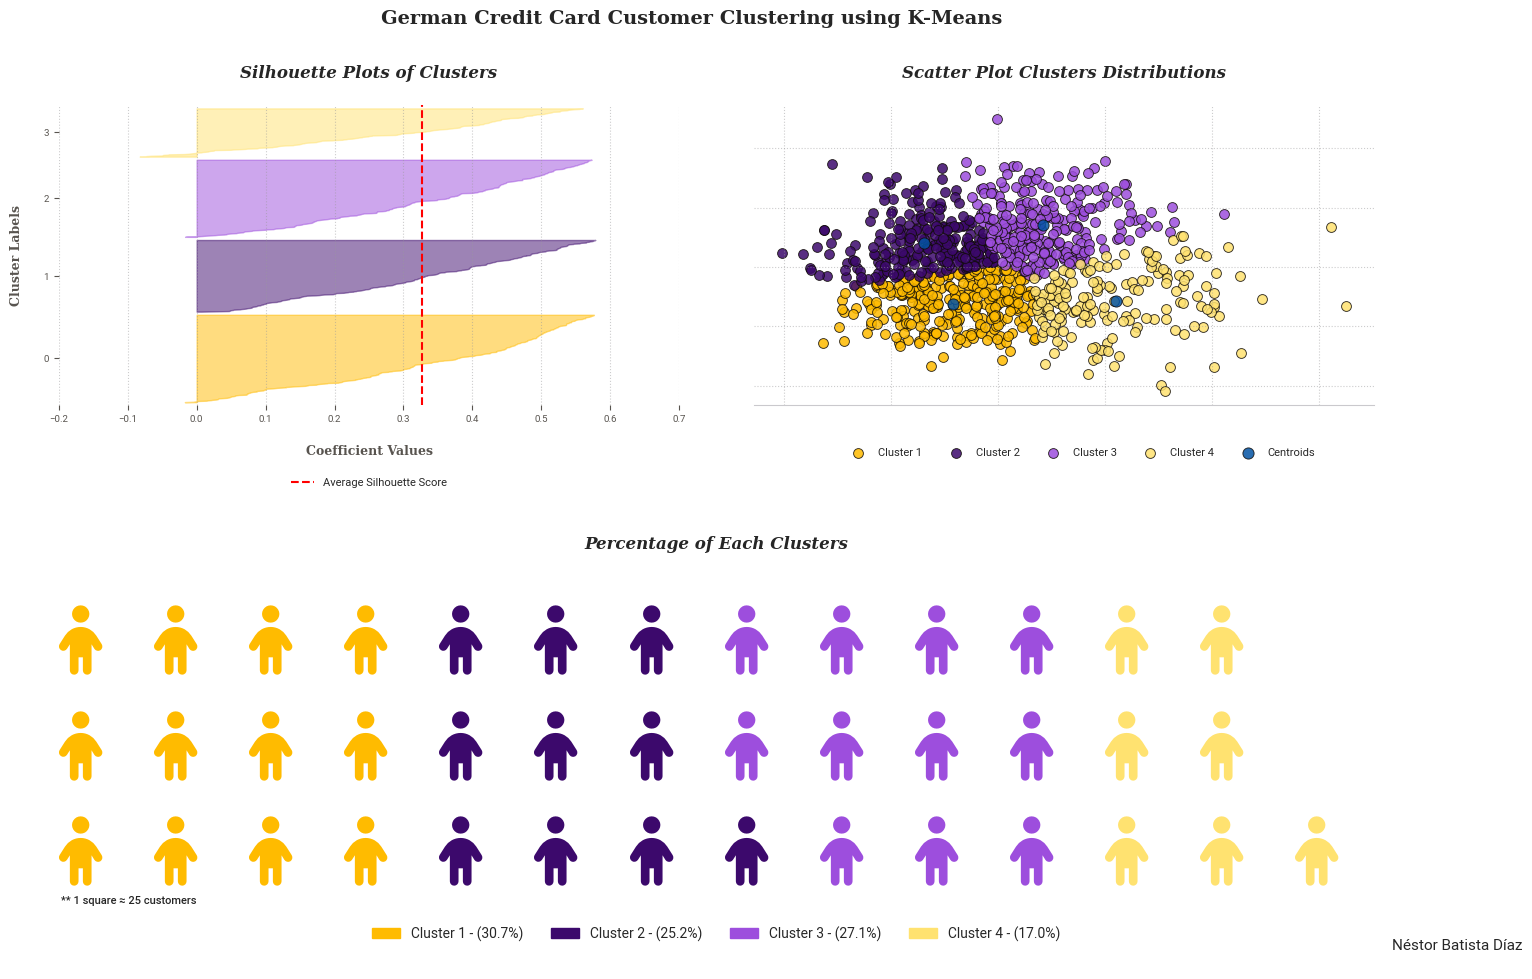

In [14]:
# --- Implementing K-Means ---
kmeans = KMeans(n_clusters=4, random_state=32, max_iter=500)
y_kmeans = kmeans.fit_predict(X)
    
# --- Define K-Means Visualizer & Plots ---
def visualizer(kmeans, y_kmeans):
    
    # --- Figures Settings ---
    cluster_colors=['#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Centroids']
    title=dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    text_style=dict(fontweight='bold', fontfamily='serif')
    scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
    legend_style=dict(borderpad=2, frameon=False, fontsize=8)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # --- Silhouette Plots ---
    s_viz = SilhouetteVisualizer(kmeans, ax=ax1, colors=cluster_colors)
    s_viz.fit(X)
    s_viz.finalize()
    s_viz.ax.set_title('Silhouette Plots of Clusters\n', **title)
    s_viz.ax.tick_params(labelsize=7)
    for text in s_viz.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in s_viz.ax.spines.values():
        spine.set_color('None')
    s_viz.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), **legend_style)
    s_viz.ax.grid(axis='x', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    s_viz.ax.grid(axis='y', alpha=0)
    s_viz.ax.set_xlabel('\nCoefficient Values', fontsize=9, **text_style)
    s_viz.ax.set_ylabel('Cluster Labels\n', fontsize=9, **text_style)
        
    # --- Clusters Distribution ---
    y_kmeans_labels = list(set(y_kmeans.tolist()))
    for i in y_kmeans_labels:
        ax2.scatter(X[y_kmeans==i, 0], X[y_kmeans == i, 1], s=50, c=cluster_colors[i], **scatter_style)
    ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=65, c='#0353A4', label='Centroids', **scatter_style)
    for spine in ax2.spines.values():
        spine.set_color('None')
    ax2.set_title('Scatter Plot Clusters Distributions\n', **title)
    ax2.legend(labels, bbox_to_anchor=(0.95, -0.05), ncol=5, **legend_style)
    ax2.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    ax2.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['bottom'].set_color('#CAC9CD')
    
    # --- Waffle Chart ---
    unique, counts = np.unique(y_kmeans, return_counts=True)
    df_waffle = dict(zip(unique, counts))
    total = sum(df_waffle.values())
    wfl_square = {key: value/25 for key, value in df_waffle.items()}
    wfl_label = {key: round(value/total*100, 2) for key, value in df_waffle.items()}
    
    # --- Not show axes
    ax4.set_frame_on(False)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax3.set_frame_on(False)
    ax3.set_yticks([])
    ax3.set_xticks([])

    ax3=plt.subplot(2, 2, (3,4))
    ax3.set_title('Percentage of Each Clusters\n', **title)
    ax3.set_aspect(aspect='auto')
    

    Waffle.make_waffle(ax=ax3, rows=3, values=wfl_square, colors=cluster_colors, 
                       labels=[f"Cluster {i+1} - ({k}%)" for i, k in wfl_label.items()], icons="child", icon_size=50,
                       legend={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.05), 'ncol': 4, 'borderpad': 2, 
                               'frameon': False, 'fontsize':10})
    ax3.text(0.01, -0.09, '** 1 square ≈ 25 customers', weight = 'bold', style='italic', fontsize=8)
    

    
    # --- Suptitle & WM ---
    plt.suptitle('German Credit Card Customer Clustering using K-Means\n', fontsize=14, **text_style)
    plt.tight_layout()
    plt.gcf().text(1, 0.04, 'Néstor Batista Díaz', style='italic', fontsize=11)
    plt.show();
    
# --- Calling K-Means Functions ---
visualizer(kmeans, y_kmeans);

In [15]:
# --- Evaluate Clustering Quality Function ---
def evaluate_clustering(X, y):
    db_index = round(davies_bouldin_score(X, y), 3)
    s_score = round(silhouette_score(X, y), 3)
    ch_index = round(calinski_harabasz_score(X, y), 3)
    print(clr.start+'.: Evaluate Clustering Quality :.'+clr.end)
    print(clr.start+'*' * 34+clr.end)
    print(clr.end+'.: Davies-Bouldin Index: '+clr.color, db_index)
    print(clr.end+'.: Silhouette Score: '+clr.color, s_score)
    print(clr.end+'.: Calinski Harabasz Index: '+clr.color, ch_index)
    return db_index, s_score, ch_index

# --- Evaluate K-Means Cluster Quality ---
db_kmeans, ss_kmeans, ch_kmeans = evaluate_clustering(X, y_kmeans)

.: Evaluate Clustering Quality :.
**********************************
.: Davies-Bouldin Index:  0.943
.: Silhouette Score:  0.327
.: Calinski Harabasz Index:  658.413


### DBSCAN

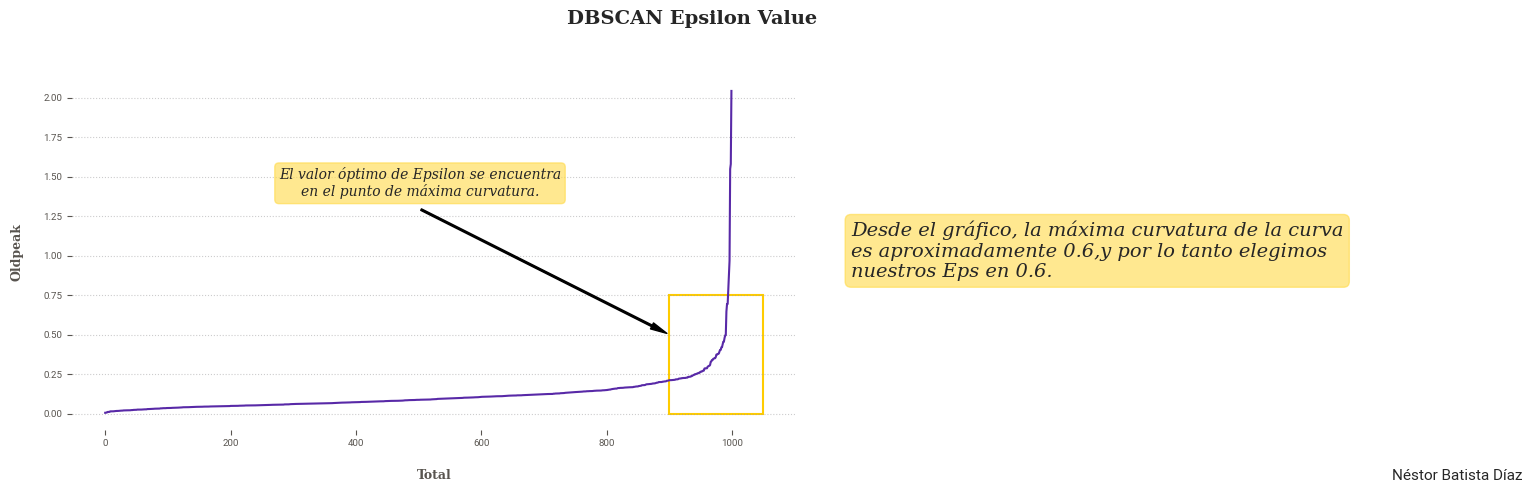

In [17]:
# --- Define Epsilon Values ---
def epsilon():
    
    # --- Calculate Nearest Neighbors ---
    neighbors=NearestNeighbors(n_neighbors=2)
    nbrs=neighbors.fit(X)
    distances, indices=nbrs.kneighbors(X)
    distances=np.sort(distances, axis = 0)
    
    # --- Figure Settings ---
    bbox=dict(boxstyle='round', pad=0.3, color='#FFDA47', alpha=0.6)
    txt1=dict(textcoords='offset points', va='center', ha='center', fontfamily='serif', style='italic')
    txt2=dict(textcoords='offset points', va='center', fontfamily='serif', style='italic')
    kw=dict(arrowstyle='Simple, tail_width=0.1, head_width=0.4, head_length=1', color='black')
    text_style=dict(fontweight='bold', fontfamily='serif')
    fig=plt.figure(figsize=(14, 5))
    
    # --- Epsilon Plot ---
    distances_1=distances[:, 1]
    ax1=fig.add_subplot(1, 3, (1, 2))
    plt.plot(distances_1, color='#5829A7')
    plt.xlabel('\nTotal', fontsize=9, **text_style)
    plt.ylabel('Oldpeak\n', fontsize=9, **text_style)
    ax1.add_patch(Rectangle((900, 0), 150, 0.75, edgecolor='#FFCC00', fill=False, lw=1.5))
    plt.annotate('El valor óptimo de Epsilon se encuentra\nen el punto de máxima curvatura.', xy=(500, 1.45), xytext=(1, 1), fontsize=10, bbox=bbox, **txt1)
    plt.annotate('', xy=(900, 0.5), xytext=(500, 1.3), arrowprops=kw)
    for spine in ax1.spines.values():
        spine.set_color('None')
    plt.grid(axis='y', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.grid(axis='x', alpha=0)
    plt.tick_params(labelsize=7)
    
    # --- Explanations ---
    ax2=fig.add_subplot(1, 3, 3)
    plt.annotate('Desde el gráfico, la máxima curvatura de la curva\nes aproximadamente 0.6,y por lo tanto elegimos\nnuestros Eps en 0.6.', xy=(0.1, 0.5), xytext=(1, 1), fontsize=14, bbox=bbox, **txt2)
    for spine in ax2.spines.values():
        spine.set_color('None')
    plt.grid(axis='both', alpha=0)
    plt.axis('off')
    
    plt.suptitle('DBSCAN Epsilon Value\n', fontsize=14, **text_style)
    plt.tight_layout()
    plt.gcf().text(1, 0.04, 'Néstor Batista Díaz', style='italic', fontsize=11)
    plt.show();

# --- Calling Epsilon Functions ---
epsilon();

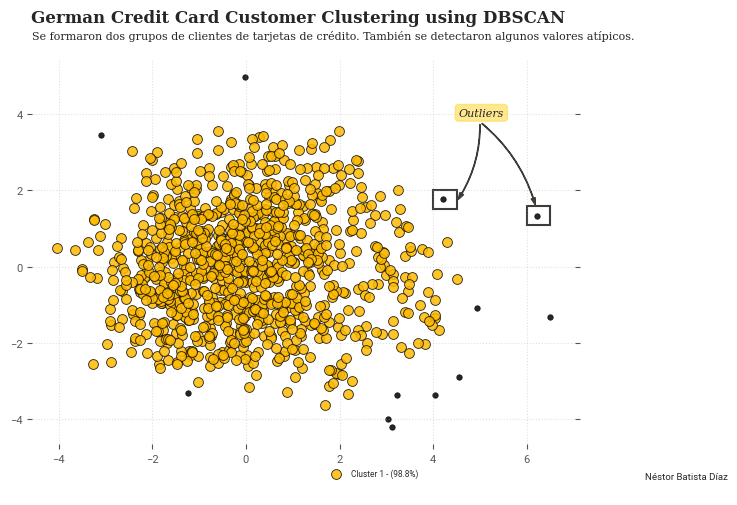

In [30]:
# --- Implementing DBSCAN ---
dbscan = DBSCAN(eps=0.6, min_samples=4)
y_dbscan = dbscan.fit_predict(X)
    
# --- Define DBSCAN Result Distribution ---
def dbscan_visualizer(dbscan, y_dbscan):
    
    # --- Figures Settings ---
    cluster_colors=['#FFBB00', '#9D4EDD', 'black']
    labels = ['Cluster 1', 'Cluster 2', 'Outliers']
    suptitle=dict(fontsize=12, fontweight='heavy', fontfamily='serif')
    title=dict(fontsize=8, fontfamily='serif')
    scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
    bbox=dict(boxstyle='round', pad=0.3, color='#FFDA47', alpha=0.6)
    txt=dict(textcoords='offset points', va='center', ha='center', fontfamily='serif', style='italic')
    legend_style=dict(borderpad=2, frameon=False, fontsize=6)
    
    # --- Arrow Settings ---
    style = 'Simple, tail_width=0.3, head_width=3, head_length=5'
    kw = dict(arrowstyle=style, color='#3E3B39')
    arrow1 = patches.FancyArrowPatch((5, 3.8), (6.2, 1.55), connectionstyle='arc3, rad=-0.16', **kw)
    arrow2 = patches.FancyArrowPatch((5, 3.8), (4.5, 1.7), connectionstyle='arc3, rad=-0.16', **kw)
    
    # --- Percentage labels ---
    unique, counts = np.unique(y_dbscan, return_counts=True)
    dbscan_count = dict(zip(unique, counts))
    total = sum(dbscan_count.values())
    dbscan_label = {key: round(value/total*100, 2) for key, value in dbscan_count.items() if key != -1}

    # --- Clusters Distribution ---
    y_dbscan_labels = list(set(y_dbscan.tolist()))
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for i in np.arange(0, 2, 1):
        plt.scatter(X[y_dbscan==i, 0], X[y_dbscan == i, 1], s=50, c=cluster_colors[i], label=labels[i], **scatter_style)
    plt.scatter(X[y_dbscan==-1, 0], X[y_dbscan == -1, 1], s=15, c=cluster_colors[2], label=labels[2], **scatter_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    plt.legend([f"Cluster {i+1} - ({k}%)" for i, k in dbscan_label.items()], bbox_to_anchor=(0.75, -0.01), ncol=3, **legend_style)
    plt.grid(axis='both', alpha=0.3, color='#9B9A9C', linestyle='dotted')
    ax.add_patch(Rectangle((4, 1.5), 0.5, 0.5, edgecolor='#3E3B39', fill=False, lw=1.5))
    ax.add_patch(Rectangle((6, 1.1), 0.5, 0.5, edgecolor='#3E3B39', fill=False, lw=1.5))
    ax.add_patch(arrow1)
    ax.add_patch(arrow2)
    plt.annotate('Outliers', xy=(5, 4), xytext=(1, 1), fontsize=8, bbox=bbox, **txt)
    plt.tick_params(left=True, right=True , labelleft=True , labelbottom=True, bottom=True)
    plt.title('Se formaron dos grupos de clientes de tarjetas de crédito. También se detectaron algunos valores atípicos.\n', loc='left', **title)
    plt.suptitle('German Credit Card Customer Clustering using DBSCAN', x=0.123, y=0.98, ha='left', **suptitle)
    plt.gcf().text(1, 0.04, 'Néstor Batista Díaz', style='italic', fontsize=7)
    plt.show();
    
# --- Calling DBSCAN Functions ---
dbscan_visualizer(dbscan, y_dbscan);

In [31]:
# --- Evaluate DBSCAN Cluster Quality ---
db_dbscan, ss_dbscan, ch_dbscan = evaluate_clustering(X, y_dbscan)

.: Evaluate Clustering Quality :.
**********************************
.: Davies-Bouldin Index:  1.792
.: Silhouette Score:  0.486
.: Calinski Harabasz Index:  25.881


### Hierarchical Clustering (Agglomerative)

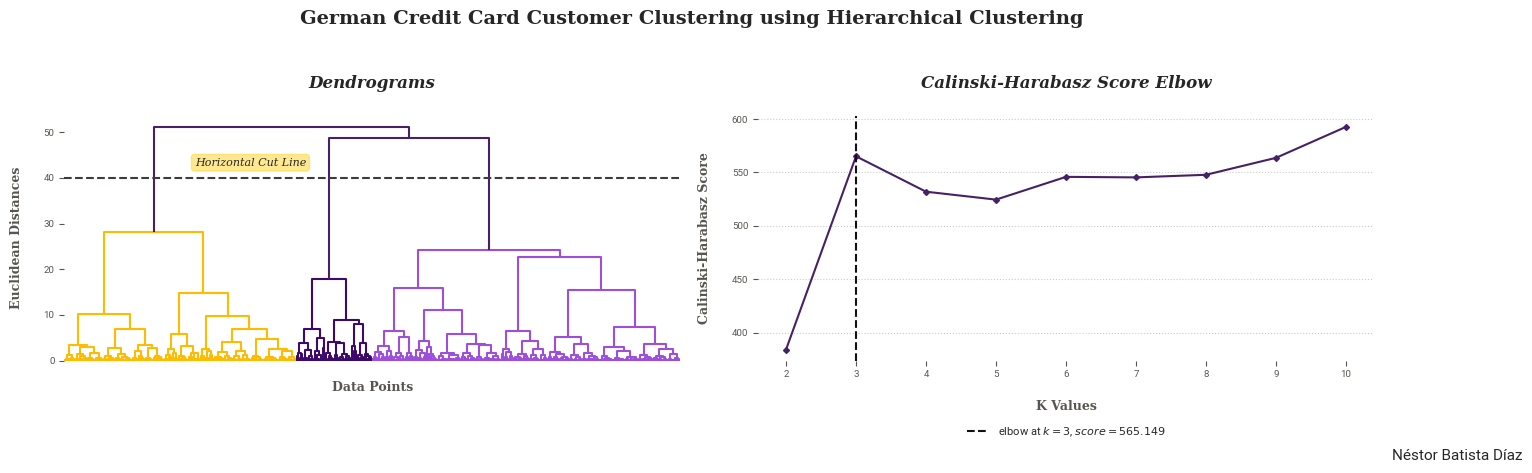

In [34]:
# --- Define Dendrogram ---
def agg_dendrogram():
    
    # --- Figure Settings ---
    color_palette=['#472165', '#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
    set_palette(color_palette)
    text_style=dict(fontweight='bold', fontfamily='serif')
    ann=dict(textcoords='offset points', va='center', ha='center', fontfamily='serif', style='italic')
    title=dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    bbox=dict(boxstyle='round', pad=0.3, color='#FFDA47', alpha=0.6)
    fig=plt.figure(figsize=(14, 5))
    
    # --- Dendrogram Plot ---
    ax1=fig.add_subplot(1, 2, 1)
    dendrogram(linkage(X, method='ward', metric='euclidean'))
    plt.axhline(y=40, color='#3E3B39', linestyle='--')
    plt.xlabel('\nData Points', fontsize=9, **text_style)
    plt.ylabel('Euclidean Distances\n', fontsize=9, **text_style)
    plt.annotate('Horizontal Cut Line', xy=(3000, 43), xytext=(1, 1), fontsize=8, bbox=bbox, **ann)
    plt.tick_params(labelbottom=False)
    for spine in ax1.spines.values():
        spine.set_color('None')
    plt.grid(axis='both', alpha=0)
    plt.tick_params(labelsize=7)
    plt.title('Dendrograms\n', **title)
    
    # --- Elbow Score (Calinski-Harabasz Index) ---
    ax2=fig.add_subplot(1, 2, 2)
    elbow_score_ch = KElbowVisualizer(AgglomerativeClustering(), metric='calinski_harabasz', timings=False, ax=ax2)
    elbow_score_ch.fit(X)
    elbow_score_ch.finalize()
    elbow_score_ch.ax.set_title('Calinski-Harabasz Score Elbow\n', **title)
    elbow_score_ch.ax.tick_params(labelsize=7)
    for text in elbow_score_ch.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in elbow_score_ch.ax.spines.values():
        spine.set_color('None')
    elbow_score_ch.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), borderpad=2, frameon=False, fontsize=8)
    elbow_score_ch.ax.grid(axis='y', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    elbow_score_ch.ax.grid(axis='x', alpha=0)
    elbow_score_ch.ax.set_xlabel('\nK Values', fontsize=9, **text_style)
    elbow_score_ch.ax.set_ylabel('Calinski-Harabasz Score\n', fontsize=9, **text_style)
    
    plt.suptitle('German Credit Card Customer Clustering using Hierarchical Clustering\n', fontsize=14, **text_style)
    plt.gcf().text(1, 0.08, 'Néstor Batista Díaz', style='italic', fontsize=11)
    plt.tight_layout()
    plt.show();

# --- Calling Dendrogram Functions ---
agg_dendrogram();

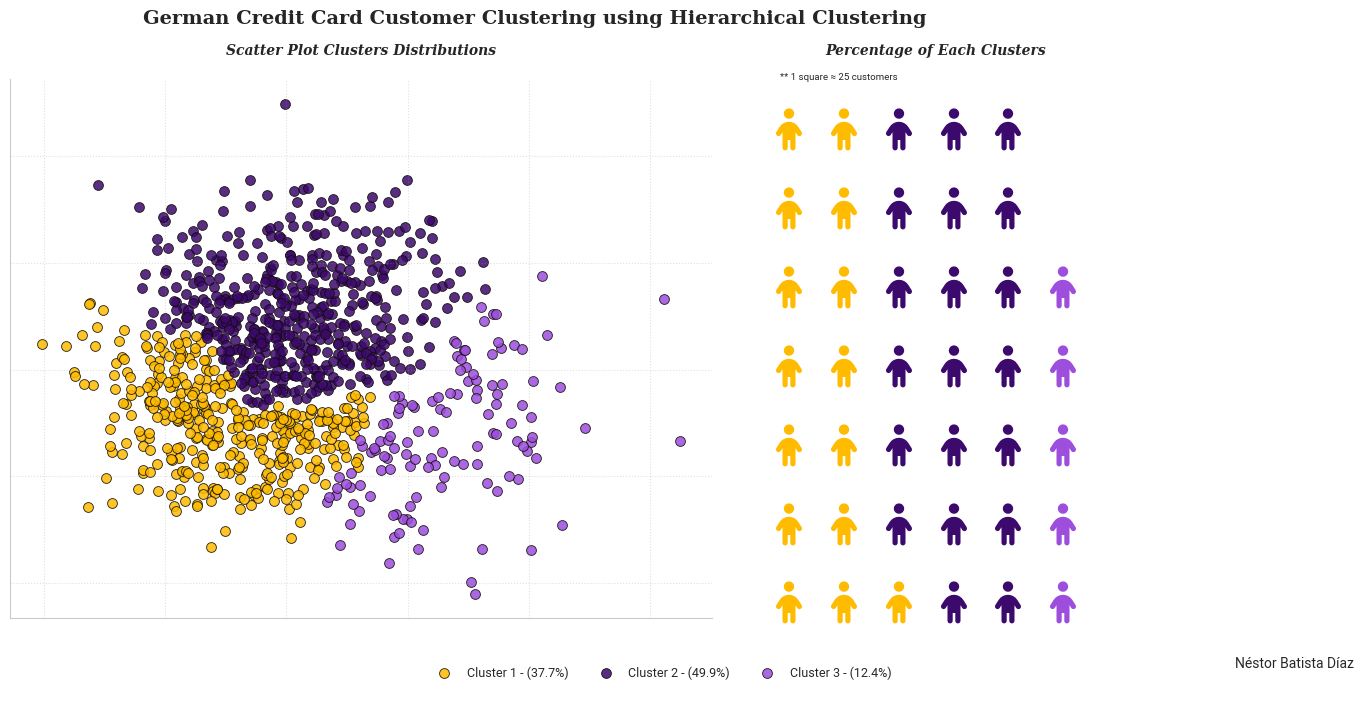

In [36]:
# --- Implementing Hierarchical Clustering ---
agg_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
y_agg_cluster = agg_cluster.fit_predict(X)
    
# --- Define Hierarchical Clustering Distributions ---
def agg_visualizer(agg_cluster, y_agg_cluster):
    
    # --- Figures Settings ---
    cluster_colors=['#FFBB00', '#3C096C', '#9D4EDD']
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']
    suptitle=dict(fontsize=14, fontweight='heavy', fontfamily='serif')
    title=dict(fontsize=10, fontweight='bold', style='italic', fontfamily='serif')
    scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
    legend_style=dict(borderpad=2, frameon=False, fontsize=9)
    fig=plt.figure(figsize=(14, 7))
    
    # --- Percentage Labels ---
    unique, counts = np.unique(y_agg_cluster, return_counts=True)
    df_waffle = dict(zip(unique, counts))
    total = sum(df_waffle.values())
    wfl_square = {key: value/25 for key, value in df_waffle.items()}
    wfl_label = {key: round(value/total*100, 2) for key, value in df_waffle.items()}

    # --- Clusters Distribution ---
    y_agg_labels = list(set(y_agg_cluster.tolist()))
    ax1=fig.add_subplot(1, 3, (1, 2))
    for i in y_agg_labels:
        ax1.scatter(X[y_agg_cluster==i, 0], X[y_agg_cluster == i, 1], s=50, c=cluster_colors[i], label=labels[i], **scatter_style)
    for spine in ax1.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax1.spines[spine].set_visible(True)
        ax1.spines[spine].set_color('#CAC9CD')
    ax1.legend([f"Cluster {i+1} - ({k}%)" for i, k in wfl_label.items()], bbox_to_anchor=(1.3, -0.03), ncol=5, **legend_style)
    ax1.grid(axis='both', alpha=0.3, color='#9B9A9C', linestyle='dotted')
    ax1.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)
    plt.title('Scatter Plot Clusters Distributions\n', **title)
    
    # --- Waffle Chart ---
    ax2=fig.add_subplot(1, 3, 3)
    ax2.set_title('Percentage of Each Clusters\n', **title)
    ax2.set_aspect(aspect='auto')
    Waffle.make_waffle(ax=ax2, rows=7, values=wfl_square, colors=cluster_colors, icons='child', icon_size=30)
    ax2.get_legend().remove()
    ax2.text(0.01, 1, '** 1 square ≈ 25 customers', style='italic', fontsize=7)
    
    plt.suptitle('German Credit Card Customer Clustering using Hierarchical Clustering\n', **suptitle)
    plt.gcf().text(1, 0.04, 'Néstor Batista Díaz', style='italic', fontsize=10)
    plt.show();
    
# --- Calling Hierarchical Clustering Functions ---
agg_visualizer(agg_cluster, y_agg_cluster);

In [37]:
# --- Evaluate DBSCAN Cluster Quality ---
db_agg, ss_agg, ch_agg = evaluate_clustering(X, y_agg_cluster)

.: Evaluate Clustering Quality :.
**********************************
.: Davies-Bouldin Index:  0.987
.: Silhouette Score:  0.335
.: Calinski Harabasz Index:  565.149


## CONCLUSIÓN

In [38]:
# --- Comparison Table ---
compare = pd.DataFrame({'Model': ['K-Means', 'DBSCAN', 'Hierarchical Clustering'], 
                        'Davies-Bouldin Index': [db_kmeans, db_dbscan, db_agg],
                        'Silhouette Score': [ss_kmeans, ss_dbscan, ss_agg],
                       'Calinski-Harabasz Index': [ch_kmeans, ch_dbscan, ch_agg]})

# --- Create Accuracy Comparison Table ---
print(clr.start+'.: Model Accuracy Comparison :.'+clr.end)
print(clr.start+'*' * 32+clr.end)
compare.sort_values(by='Model', ascending=False).style.hide(axis="index")

.: Model Accuracy Comparison :.
********************************


Model,Davies-Bouldin Index,Silhouette Score,Calinski-Harabasz Index
K-Means,0.943000,0.327000,658.413000
Hierarchical Clustering,0.987000,0.335000,565.149000
DBSCAN,1.792000,0.486000,25.881000


In [39]:
# --- Add K-Means Prediction to Data Frame ----
df['cluster_result'] = y_kmeans+1
df['cluster_result'] = 'Cluster '+df['cluster_result'].astype(str)


# --- Calculationg Overall Mean from Current Data Frame ---
df_profile_overall = pd.DataFrame()
df_profile_overall['Overall'] = df.describe().loc[['mean']].T

# --- Summarize Mean of Each Clusters --- 
df_cluster_summary = df.groupby('cluster_result').describe().T.reset_index().rename(columns={'level_0': 'Column Name', 'level_1': 'Metrics'})
df_cluster_summary = df_cluster_summary[df_cluster_summary['Metrics'] == 'mean'].set_index('Column Name')


# --- Combining Both Data Frame ---
print(clr.start+'.: Summarize of Each Clusters :.'+clr.end)
print(clr.start+'*' * 33)
df_profile = df_cluster_summary.join(df_profile_overall).reset_index()
df_profile.style.hide(axis="index")

.: Summarize of Each Clusters :.
*********************************


Column Name,Metrics,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Overall
Attribute1,mean,0.931596,2.027778,2.158672,1.147059,1.577000
Attribute2,mean,19.052117,12.583333,21.059041,36.329412,20.903000
Attribute3,mean,1.964169,2.869048,3.166052,2.123529,2.545000
Attribute4,mean,3.270358,3.238095,3.247232,3.394118,3.277000
Attribute5,mean,2577.671010,1735.321429,3040.166052,7168.982353,3271.258000
Attribute6,mean,0.641694,1.035714,1.763838,0.994118,1.105000
Attribute7,mean,1.791531,2.369048,3.121771,2.300000,2.384000
Attribute8,mean,2.859935,2.849206,3.295203,2.847059,2.973000
Attribute9,mean,1.514658,1.773810,1.808118,1.647059,1.682000
Attribute10,mean,0.208469,0.182540,0.066421,0.100000,0.145000


## EXPORTAR A EXCEL

In [40]:
df.to_excel('results.xlsx', index=False)